In [1]:
from multiprocessing import Pool
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

from dataset import SyntheticBanditDatasetWithActionEmbeds
from estimator import InversePropensityScore as IPS
from estimator import MarginalizedIPS as MIPS
from estimator_tuning import SLOPE
from importance_weight import marginal_weight
from lower_bound import estimate_student_t_lower_bound
from policy import gen_eps_greedy
from util import ActionEmbedOffPolicyEvaluation, aggregate_simulation_results, visualize_mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# setting 1

# 変数
n_actions_list=[250, 500, 700, 1000]

# 定数
dim_context=5
n_cat_dim=3
n_cat_per_dim=5
latent_param_mat_dim=4
val_size=3000
test_size=10000
eps=0.5
reward_noise=1.0
beta=1.0
n_sim=300
random_state=12345
ope_estimators = [
    IPS(estimator_name="IPS"), 
    MIPS(estimator_name="MIPS (true)"),
    MIPS(estimator_name="MIPS"),
]

In [ ]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of action")

In [ ]:
# experiment-1 varying n_actions under the assumption that p(r|x,a,e) = p(r|x,e)

result_df_list = []
for n_actions in n_actions_list:
    
    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_actions,
        dim_context=dim_context,
        n_cat_dim=n_cat_dim,
        n_cat_per_dim=n_cat_per_dim,
        latent_param_mat_dim=latent_param_mat_dim,
        reward_noise=reward_noise,
        beta=beta,
        random_state=random_state
    )

    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
    )
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"n_actions={n_actions}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        
        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=evaluation_policy)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=n_actions
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

n_actions=250...: 100% 300/300 [02:11<00:00,  2.29it/s]
n_actions=500...: 100% 300/300 [03:31<00:00,  1.42it/s]
n_actions=700...: 100% 300/300 [04:25<00:00,  1.13it/s]
n_actions=1000...:   8% 23/300 [00:27<05:27,  1.18s/it]

In [11]:
# setting 2

# 変数
val_size_list=[250, 500, 1000, 2000]

# 定数
dim_context=5
n_cat_dim=3
n_cat_per_dim=10
latent_param_mat_dim=4
n_actions=1000
test_size=10000
eps=0.5
reward_noise=1.0
beta=1.0
n_sim=300
random_state=12345
ope_estimators = [
    IPS(estimator_name="IPS"), 
    MIPS(estimator_name="MIPS (true)"),
    MIPS(estimator_name="MIPS"),
]

In [12]:
# experiment-2 varying number of data under the assumption that p(r|x,a,e) = p(r|x,e)

dataset = SyntheticBanditDatasetWithActionEmbeds(
    n_actions=n_actions,
    dim_context=dim_context,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    latent_param_mat_dim=latent_param_mat_dim,
    reward_noise=reward_noise,
    beta=beta,
    random_state=random_state
)

test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
policy_value = dataset.calc_ground_truth_policy_value(
    expected_reward=test_data["expected_reward"],
    evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
)
    

result_df_list = []
for val_size in val_size_list:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        
        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=evaluation_policy)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=250...: 100% 300/300 [00:45<00:00,  6.66it/s]
val_size=500...: 100% 300/300 [02:09<00:00,  2.32it/s]
val_size=1000...: 100% 300/300 [05:06<00:00,  1.02s/it]
val_size=2000...: 100% 300/300 [13:19<00:00,  2.66s/it]


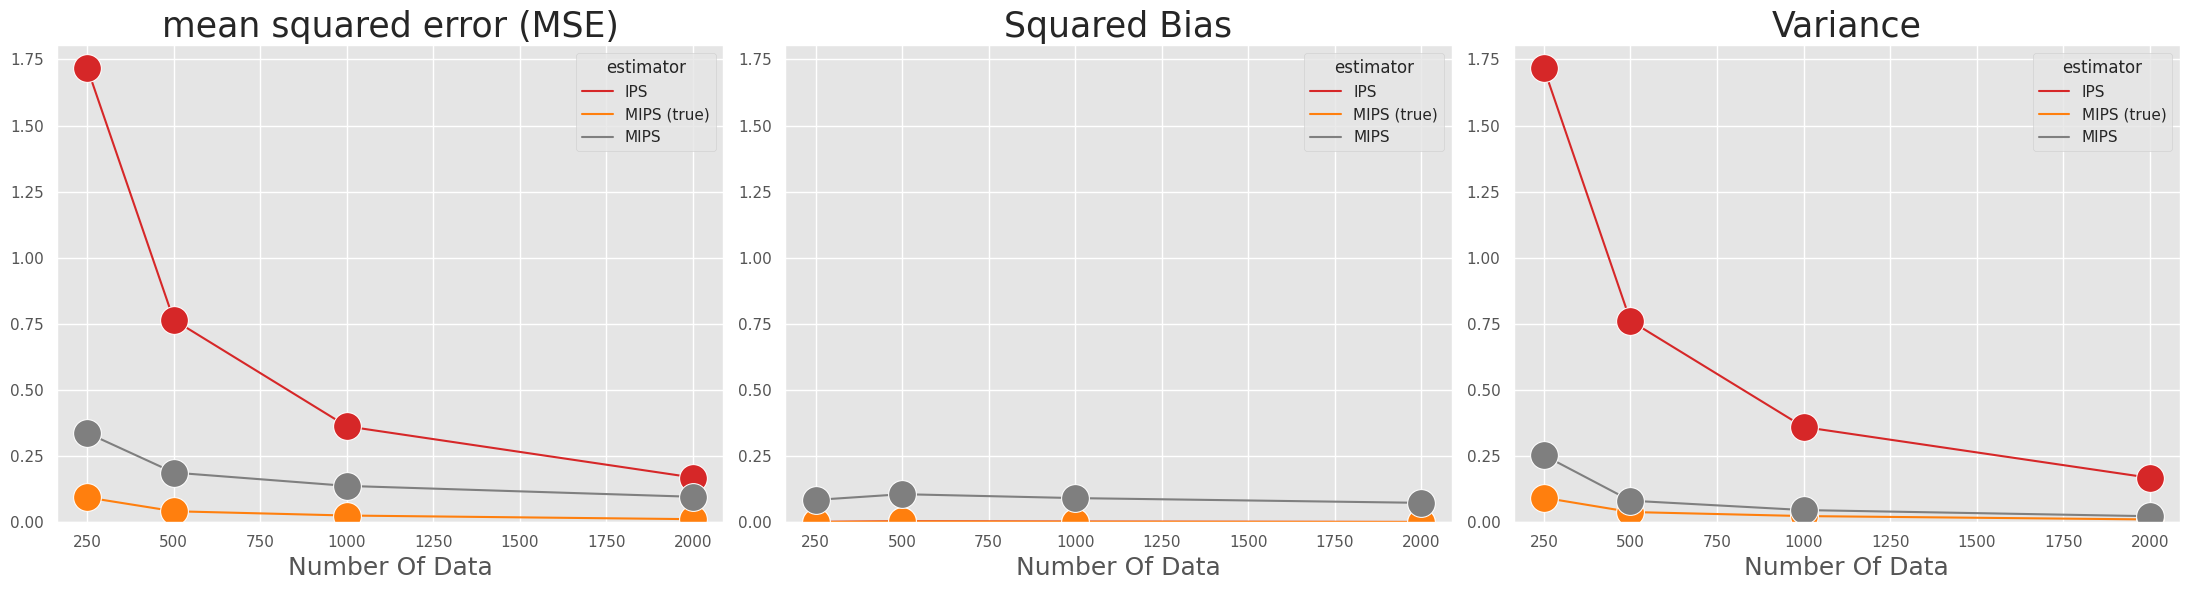

In [13]:
visualize_mean_squared_error(result_df=result_df, xlabel="Number Of Data")

In [3]:
# setting 3

# 変数
n_unobserved_cat_dim_list=[0, 4, 8, 12, 16]

# 定数
dim_context=3
n_cat_dim=17
n_cat_per_dim=2
latent_param_mat_dim=3
n_actions=500
val_size=1000
test_size=10000
eps=0.1
reward_noise=1.0
beta=1.0
n_sim=200
random_state=12345
ope_estimators = [
    IPS(estimator_name="IPS"), 
    MIPS(estimator_name="MIPS (true)"),
    MIPS(estimator_name="MIPS"),
]

In [4]:
# experiment-3 varying number of replace category under the assumption that p(r|x,a,e) = p(r|x,e)

result_df_list = []
for n_unobserved_cat_dim in n_unobserved_cat_dim_list:
    
    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_actions,
        dim_context=dim_context,
        n_cat_dim=n_cat_dim,
        n_cat_per_dim=n_cat_per_dim,
        latent_param_mat_dim=latent_param_mat_dim,
        reward_noise=reward_noise,
        beta=beta,
        random_state=random_state,
        n_unobserved_cat_dim=n_unobserved_cat_dim
    )

    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
    )
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"n_unobserved_cat_dim={n_unobserved_cat_dim}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        
        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=evaluation_policy)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=n_unobserved_cat_dim
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

n_unobserved_cat_dim=0...: 100% 200/200 [03:39<00:00,  1.10s/it]
n_unobserved_cat_dim=4...: 100% 200/200 [03:09<00:00,  1.05it/s]
n_unobserved_cat_dim=8...: 100% 200/200 [02:40<00:00,  1.25it/s]
n_unobserved_cat_dim=12...: 100% 200/200 [02:05<00:00,  1.59it/s]
n_unobserved_cat_dim=16...: 100% 200/200 [01:38<00:00,  2.02it/s]


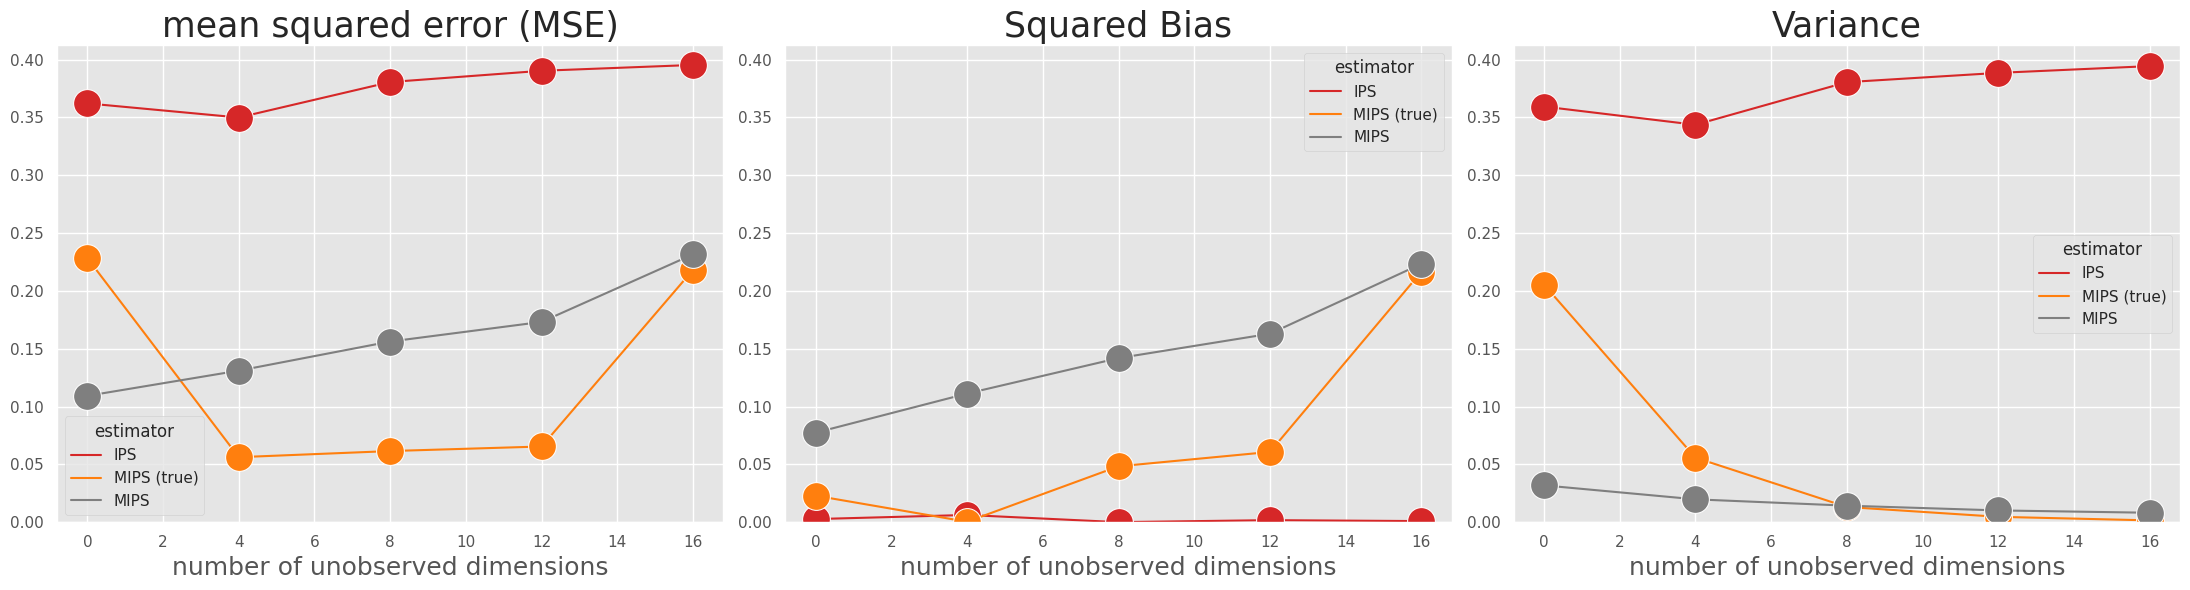

In [5]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of unobserved dimensions")

In [22]:
# setting 4 select the dimension of the action embedding which is a trade-off between bias and variance by SLOPE

# 変数
val_size_list=[250, 500, 1000, 2000]

# 定数
dim_context=5
n_cat_dim=10
n_cat_per_dim=15
latent_param_mat_dim=4
n_actions=500
test_size=10000
eps=0.5
reward_noise=1.0
beta=1.0
n_sim=100
random_state=12345
ope_estimators = [MIPS(estimator_name="MIPS (true)")]
ope_estimators_tune = [
    SLOPE(
        estimator=MIPS(estimator_name="MIPS (true)-SLOPE"),
        hyper_param=np.arange(n_cat_dim),
        param_name="action_embed_dim",
        lower_bound_func=estimate_student_t_lower_bound,
        weight_func=marginal_weight,
        tuning_method="greedy_combination",
        min_combination=3
    )
]

In [23]:
def simulate_evaluation(args):
    dataset, val_size, eps = args
    # generate synthetic data
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
    # evaluation policy
    evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        
    # off policy evaluation
    ope = ActionEmbedOffPolicyEvaluation(
        bandit_feedback=val_data,
        ope_estimators=ope_estimators,
        ope_estimators_tune=ope_estimators_tune
    )
    estimated_policy_values = ope.estimate_policy_values(action_dist=evaluation_policy)
    
    return estimated_policy_values

In [24]:
dataset = SyntheticBanditDatasetWithActionEmbeds(
    n_actions=n_actions,
    dim_context=dim_context,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    latent_param_mat_dim=latent_param_mat_dim,
    reward_noise=reward_noise,
    beta=beta,
    random_state=random_state
)

test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
policy_value = dataset.calc_ground_truth_policy_value(
    expected_reward=test_data["expected_reward"],
    evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
)
    

result_df_list = []
for val_size in val_size_list:

    job_args = [(dataset, val_size, eps) for _ in range(n_sim)]
    with Pool(cpu_count()-1) as pool:
        imap_iter = pool.imap(simulate_evaluation, job_args)
        tqdm_ = tqdm(imap_iter, total=n_sim, desc=f"val_size={val_size}...")
        result_list = list(tqdm_)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=250...: 100% 100/100 [00:13<00:00,  7.25it/s]
val_size=500...: 100% 100/100 [00:26<00:00,  3.72it/s]
val_size=1000...: 100% 100/100 [01:14<00:00,  1.33it/s]
val_size=2000...: 100% 100/100 [03:17<00:00,  1.97s/it]


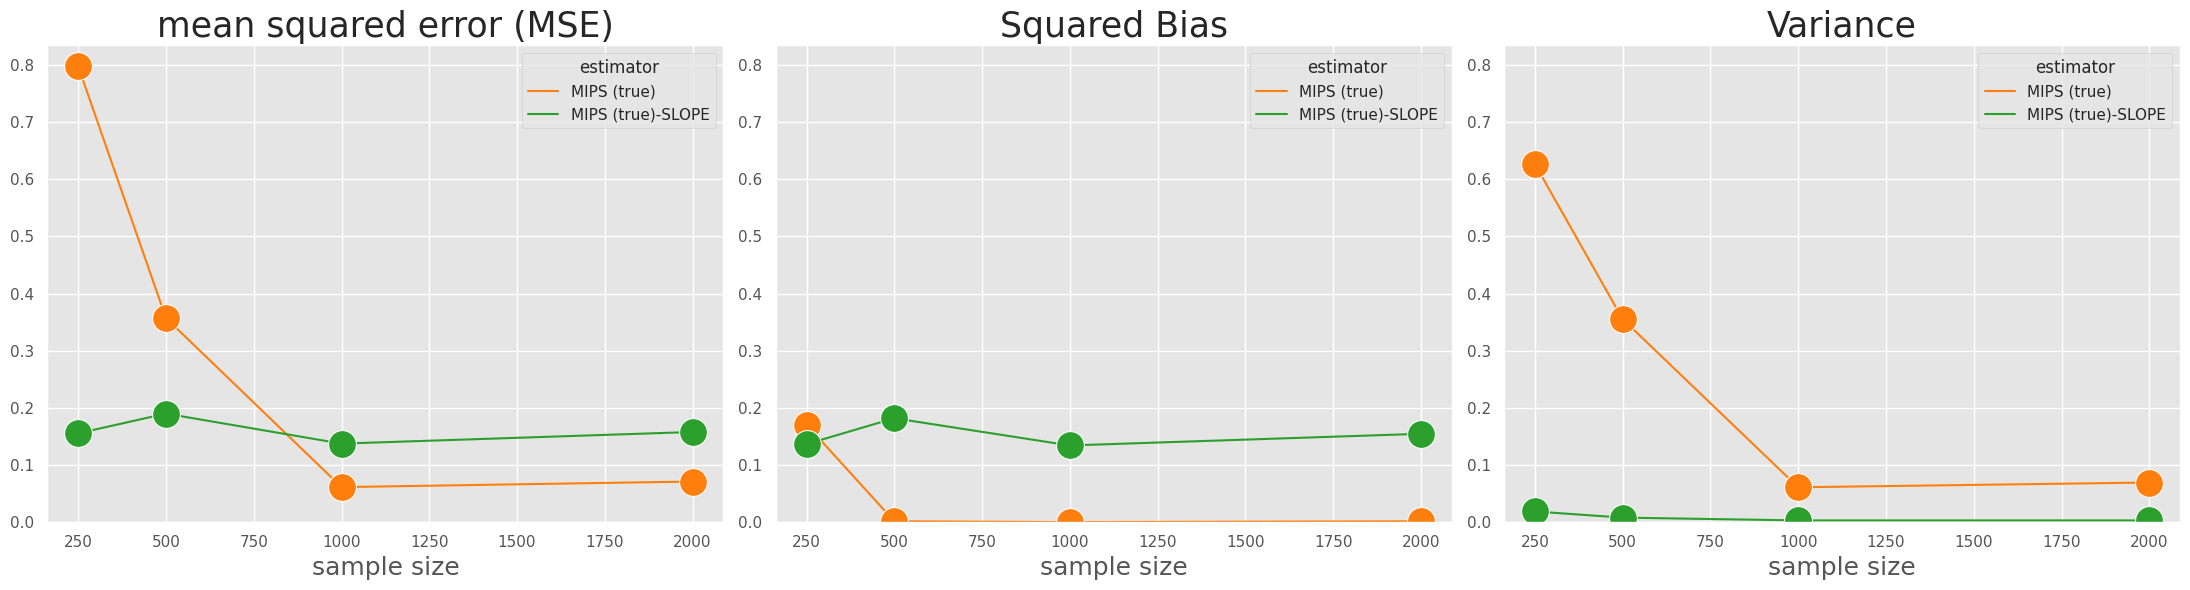

In [25]:
visualize_mean_squared_error(result_df=result_df, xlabel="sample size")